In [2]:
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

dataset_train = pd.read_csv('formatted_128714-JKH.csv')
# print(dataset_train.head)
training_set = dataset_train.iloc[:, 5:6]
training_set.dropna(inplace=True)
training_set_open = dataset_train.iloc[:, 3:4].values

dataset_train = pd.read_csv('formatted_128714-JKH.csv')
copy = pd.read_csv('formatted_128714-JKH.csv')
dataset_train = dataset_train[['DATE','OP', 'CLS']]
days = []

from datetime import datetime, timedelta

for i in range (1773):
    s = str(dataset_train.loc[i,'DATE'])
    # you could also import date instead of datetime and use that.
    date = datetime(year=int(s[0:4]), month=int(s[4:6]), day=int(s[6:8]))
    days.append(date.weekday())
    dataset_train.loc[i,'DATE'] = date.date()
    
dataset_train['DAY'] = days

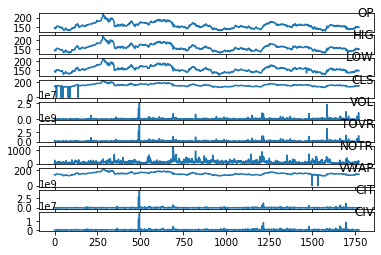

In [3]:
# load dataset
dataset = pd.read_csv('formatted_128714-JKH.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [4]:
from sklearn.preprocessing import MinMaxScaler

dataset = pd.read_csv('formatted_128714-JKH.csv')
copy = pd.read_csv('formatted_128714-JKH.csv')
dataset = dataset[['DATE','OP', 'CLS','TREND']]
days = []

from datetime import datetime, timedelta

for i in range (1773):
    s = str(dataset.loc[i,'DATE'])
    # you could also import date instead of datetime and use that.
    date = datetime(year=int(s[0:4]), month=int(s[4:6]), day=int(s[6:8]))
    days.append(date.weekday())
    dataset.loc[i,'DATE'] = date.date()
    
dataset['DAY'] = days
dataset = dataset[['DATE', 'DAY', 'CLS','TREND']]

#values = dataset.iloc[:, 1:4].values;
values = dataset[['DAY','TREND', 'CLS']]
print(values.shape)
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(values)
print(values)


# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


reframed = series_to_supervised(values, 4, 1)
print(reframed)


(1773, 3)
[[0.75       0.         0.65371429]
 [1.         0.         0.65142857]
 [0.         1.         0.66057143]
 ...
 [0.25       1.         0.69439997]
 [0.75       0.         0.68114286]
 [1.         1.         0.68617146]]
      var1(t-4)  var2(t-4)  var3(t-4)  var1(t-3)  var2(t-3)  var3(t-3)  \
4          0.75        0.0   0.653714       1.00        0.0   0.651429   
5          1.00        0.0   0.651429       0.00        1.0   0.660571   
6          0.00        1.0   0.660571       0.25        1.0   0.670857   
7          0.25        1.0   0.670857       0.50        0.0   0.668571   
8          0.50        0.0   0.668571       0.75        0.0   0.637714   
9          0.75        0.0   0.637714       1.00        1.0   0.644571   
10         1.00        1.0   0.644571       0.00        1.0   0.653714   
11         0.00        1.0   0.653714       0.25        1.0   0.670857   
12         0.25        1.0   0.670857       0.50        0.0   0.000000   
13         0.50        0.0  

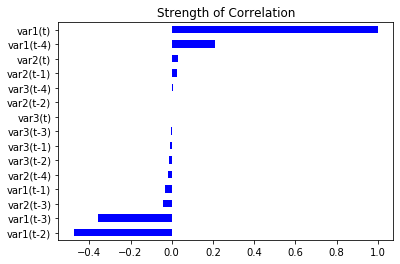

In [5]:
corr = reframed.corrwith(reframed['var1(t)'])
corr.sort_values().plot.barh(color = 'blue',title = 'Strength of Correlation')

In [6]:
# split into train and test sets
values = reframed.values
train = values[:1500, :]
val = values[1400:1525, :]
test = values[1500:, :]
# train_y = y[:150]
# test_y = y[150:]
# split into input and outputs
train_X, train_y = train[:, :-2], train[:, -1]
val_X, val_y = val[:, :-2], val[:, -1]
test_X, test_y = test[:, :-2], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
# train_y = train_y.reshape((train_y.shape[0], 1, 1))
# test_y = test_y.reshape((test_y.shape[0], 1, 1))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

(1500, 1, 13) (1500,) (125, 1, 13) (125,) (269, 1, 13) (269,)


In [7]:
train_X

array([[[0.75      , 0.        , 0.65371429, ..., 1.        ,
         0.67085714, 0.5       ]],

       [[1.        , 0.        , 0.65142857, ..., 0.        ,
         0.66857143, 0.75      ]],

       [[0.        , 1.        , 0.66057143, ..., 0.        ,
         0.63771429, 1.        ]],

       ...,

       [[0.        , 0.        , 0.68571429, ..., 1.        ,
         0.67382854, 0.        ]],

       [[0.25      , 0.        , 0.67657143, ..., 0.        ,
         0.66239997, 0.25      ]],

       [[0.75      , 0.        , 0.672     , ..., 0.        ,
         0.63542857, 0.5       ]]])

In [8]:
print(train_X)
print(train_y)
print(train_y.shape)
print(train_X.shape)


[[[0.75       0.         0.65371429 ... 1.         0.67085714 0.5       ]]

 [[1.         0.         0.65142857 ... 0.         0.66857143 0.75      ]]

 [[0.         1.         0.66057143 ... 0.         0.63771429 1.        ]]

 ...

 [[0.         0.         0.68571429 ... 1.         0.67382854 0.        ]]

 [[0.25       0.         0.67657143 ... 0.         0.66239997 0.25      ]]

 [[0.75       0.         0.672      ... 0.         0.63542857 0.5       ]]]
[0.66857143 0.63771429 0.64457143 ... 0.66239997 0.63542857 0.62994287]
(1500,)
(1500, 1, 13)


In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.regularizers import L1L2

Using TensorFlow backend.


In [10]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

W0702 10:53:24.273826 14236 deprecation_wrapper.py:119] From C:\Users\ASUS\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0702 10:53:24.287791 14236 deprecation_wrapper.py:119] From C:\Users\ASUS\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0702 10:53:24.288758 14236 deprecation_wrapper.py:119] From C:\Users\ASUS\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0702 10:53:24.486433 14236 deprecation_wrapper.py:119] From C:\Users\ASUS\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0702 10:53:24.491420 14236 deprecation.py:506] Fr

[[0.         0.         0.66239997 0.25       0.         0.63542857
  0.5        0.         0.62994287 0.75       1.         0.64868569
  1.        ]]
Step:  0


W0702 10:53:26.012114 14236 deprecation_wrapper.py:119] From C:\Users\ASUS\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 1500 samples, validate on 125 samples
Epoch 1/2
 - 1s - loss: 0.9156 - val_loss: 0.7838
Epoch 2/2
 - 0s - loss: 0.5742 - val_loss: 0.3787
Step:  20
Train on 1520 samples, validate on 125 samples
Epoch 1/2
 - 0s - loss: 0.3988 - val_loss: 0.3288
Epoch 2/2
 - 0s - loss: 0.3738 - val_loss: 0.2978
Step:  40
Train on 1540 samples, validate on 125 samples
Epoch 1/2
 - 0s - loss: 0.3591 - val_loss: 0.2655
Epoch 2/2
 - 0s - loss: 0.3463 - val_loss: 0.2579
Step:  60
Train on 1560 samples, validate on 125 samples
Epoch 1/2
 - 0s - loss: 0.3354 - val_loss: 0.2546
Epoch 2/2
 - 0s - loss: 0.3289 - val_loss: 0.2471
Step:  80
Train on 1580 samples, validate on 125 samples
Epoch 1/2
 - 0s - loss: 0.3232 - val_loss: 0.2334
Epoch 2/2
 - 0s - loss: 0.3105 - val_loss: 0.2335
Step:  100
Train on 1600 samples, validate on 125 samples
Epoch 1/2
 - 0s - loss: 0.3032 - val_loss: 0.2285
Epoch 2/2
 - 0s - loss: 0.2971 - val_loss: 0.2188
Step:  120
Train on 1620 samples, validate on 125 samples
Epoch 1/2

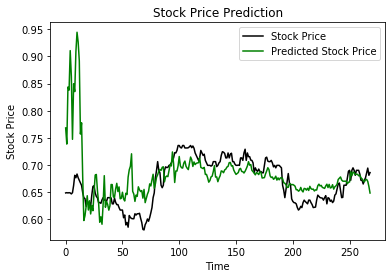

In [11]:

model = Sequential() 
model.add(LSTM(units = 128, return_sequences = True, input_shape=(train_X.shape[1], train_X.shape[2]), bias_regularizer=L1L2(l1=0.001, l2=0.001))) 
model.add(Dropout(0.5))

model.add(LSTM(units = 64)) 
model.add(Dropout(0.5))

model.add(Dense(units=16,init='uniform',activation='relu'))

model.add(Dense(units = 1)) 
model.compile(optimizer = 'adam', loss = root_mean_squared_error)

print(test_X[1])
len_x = len(test_X)
predicted_stock_price = []
a,b,c = np.shape(train_X)
#print(a)
#print(b)
#print(c)
n=0
while n < len_x:
    print('Step: ', n)
    history = model.fit(train_X, train_y, epochs = 2, batch_size=100, validation_data=(val_X, val_y), verbose=2, shuffle=False)
    p_stock_price = model.predict(test_X, batch_size = 20)
    temp = test_X[n:n+20]
    x,y,z = np.shape(temp)
    predicted_stock_price = np.append(predicted_stock_price, p_stock_price[n:n+x])
    #print(np.shape(temp))
    #print(temp)
    train_X = np.append(train_X, temp)
    train_X = np.reshape(train_X, (a+n+x,1,c))
    train_y = np.append(train_y, test_y[n:n+x])
    n=n+20


plt.plot(test_y, color = 'black', label = 'Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.savefig('predicted_stock_priceday1.png')
plt.show()






In [12]:
# plot history
#plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='validation')
#plt.legend()
#plt.show()

In [13]:
rms = np.sqrt(np.mean(np.power((np.array(test_y)-np.array(predicted_stock_price)),2)))
mse = np.mean(np.power((np.array(test_y)-np.array(predicted_stock_price)),2))
print("Root Mean Squared Error:",rms)
print("Mean Squared Error:",mse)

test2 = values[1525:, :]
test_trend = test[:, -2]

test_prices = test[:, -4]

#print(test_prices)

trend = []
i=0

for n in predicted_stock_price:
    if((n-test_prices[i])>0):
        trend.append(1)
    else:
        trend.append(0)
    i = i+1
    
#print(trend)

from sklearn.metrics import accuracy_score

print("Accuracy for trend prediction:", accuracy_score(test_trend, trend))

Root Mean Squared Error: 0.05281544294343094
Mean Squared Error: 0.0027894710133108095
Accuracy for trend prediction: 0.5427509293680297


In [14]:
# plt.plot(val2, color = 'black', label = 'Stock Price')
# plt.plot(val1, color = 'green', label = 'Predicted Stock Price')
# plt.title('Stock Price Prediction')
# plt.xlabel('Time')
# plt.ylabel('Stock Price')
# plt.legend()
# plt.savefig('predicted_stock_priceday1.png')
# plt.show()
predicted_stock_price = model.predict(test_X, batch_size = 25)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
plt.plot(test_y, color = 'black', label = 'Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
#print(np.mean(np.power((np.array(test_y)-np.array(predicted_stock_price)),2)))


ValueError: non-broadcastable output operand with shape (269,1) doesn't match the broadcast shape (269,3)